[![View notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Rozanski_and_Sonntag_1982/figs_4_5_6.ipynb)   
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=examples/PySDM_examples/Rozanski_and_Sonntag_1982/figs_4_5_6.ipynb)   
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Rozanski_and_Sonntag_1982/figs_4_5_6.ipynb)

based on [Rozanski & Sonntag 1982](https://doi.org/10.3402/tellusa.v34i2.10795)

**TODO #1207**:
- precip displacement!
- Fig. 6
- asserts for T step
- asserts for T final
- switch to the same fractionation formulae as used in the paper
- move eq. 2 to formulae
- smoke tests

In [1]:
from open_atmos_jupyter_utils import show_plot
from matplotlib import pyplot, ticker
from PySDM.physics import si, in_unit
from PySDM import Formulae, Builder, products, dynamics
from PySDM.environments import Parcel
from PySDM.backends import CPU
from PySDM.products.impl.moist_environment_product import MoistEnvironmentProduct
from PySDM_examples.utils import BasicSimulation
import numpy as np

In [20]:
formulae = Formulae(
    isotope_equilibrium_fractionation_factors='HoritaAndWesolowski1994',
    isotope_meteoric_water_line_excess='Dansgaard1964',
    isotope_ratio_evolution='MerlivatAndJouzel1979',
)
const = formulae.constants
trivia = formulae.trivia

FIG4_CAPTION_PARAMS = {
    'T_init': const.T0 + 25 * si.K,
    'T_fini': const.T0 - 10 * si.K,
    'T_step': 2 * si.K,
    'P_init': 1000 * si.mbar,
    'RH_init': 80 * const.PER_CENT,
    'delta_2H_init': -74.7 * const.PER_MILLE,  # note: R0 in the caption, but negative, hence delta
    'isotope_exchange_factor': 1,  # the "K" parameter
    'autoconversion_mixrat_threshold': 1 * si.g / si.m**3 / (1 * si.kg / si.m**3) # the "N_L" parameter, note: mixing ratio in the caption, but per-volume units, hence density
}
ARBITRARY_PARAMS = {
    'N_SUPER_DROPLETS': 1,
    'N_TIMESTEPS': 710,
    'TIMESTEP': 10 * si.s,
    'PARCEL_MASS_OF_DRY_AIR': 1 * si.kg,
    'PARCEL_VERTICAL_VELOCITY': 1 * si.m / si.s,
    'PARCEL_MONODISPERSE_DRY_AEROSOL_RADIUS': .1 * si.um,
    'PARCEL_MONODISPERSE_DRY_AEROSOL_NUMBER': (1000 / si.cm**3) * si.m**3,
    'KAPPA': 1,
}

In [3]:
class MultiBox(Parcel):
    def __init__(self, **kwargs):
        super().__init__(variables=["R_2H"], **kwargs)
    
    def advance_parcel_vars(self):
        """ explicit Euler integration of isotope-ration derivative """
        self._recalculate_temperature_pressure_relative_humidity(self._tmp)
        alpha_old = formulae.isotope_equilibrium_fractionation_factors.alpha_l_2H(self["T"][0])
        alpha_new = formulae.isotope_equilibrium_fractionation_factors.alpha_l_2H(self._tmp["T"][0])
        dR_2H__dt = self['R_2H'][0] * self.formulae.isotope_ratio_evolution.d_Rv_over_Rv(
            alpha=alpha_old,
            d_alpha=(alpha_new - alpha_old) / self.dt,
            n_vapour=self['water_vapour_mixing_ratio'][0],
            d_n_vapour=-self.delta_liquid_water_mixing_ratio / self.dt,
            n_liquid=FIG4_CAPTION_PARAMS['autoconversion_mixrat_threshold']  # TODO #1207
        )
        
        super().advance_parcel_vars()
        self.particulator.backend.explicit_euler(self._tmp["R_2H"], self.particulator.dt, dR_2H__dt)

class AmbientR2H(MoistEnvironmentProduct):
    def __init__(self, name=None, unit="dimensionless", var="R_2H"):
        super().__init__(name=name, unit=unit, var=var)

In [4]:
class Simulation(BasicSimulation):
    def __init__(self):
        env = MultiBox(
            p0=FIG4_CAPTION_PARAMS['P_init'],
            initial_water_vapour_mixing_ratio=const.eps / (
                FIG4_CAPTION_PARAMS['P_init']
                / FIG4_CAPTION_PARAMS['RH_init']
                / formulae.saturation_vapour_pressure.pvs_Celsius(FIG4_CAPTION_PARAMS['T_init'] - const.T0)
                - 1
            ),
            T0=FIG4_CAPTION_PARAMS['T_init'],
            w=ARBITRARY_PARAMS['PARCEL_VERTICAL_VELOCITY'],
            mass_of_dry_air=ARBITRARY_PARAMS['PARCEL_MASS_OF_DRY_AIR'],
            dt=ARBITRARY_PARAMS['TIMESTEP']
        )
        builder = Builder(n_sd=ARBITRARY_PARAMS['N_SUPER_DROPLETS'], backend=CPU(formulae), environment=env)
        builder.add_dynamic(dynamics.AmbientThermodynamics())
        builder.add_dynamic(dynamics.Condensation())
        attributes = env.init_attributes(
            kappa = ARBITRARY_PARAMS['KAPPA'],
            r_dry = ARBITRARY_PARAMS['PARCEL_MONODISPERSE_DRY_AEROSOL_RADIUS'],
            n_in_dv = ARBITRARY_PARAMS['PARCEL_MONODISPERSE_DRY_AEROSOL_NUMBER']
        )

        env["R_2H"][:] = formulae.trivia.isotopic_delta_2_ratio(
            delta=FIG4_CAPTION_PARAMS['delta_2H_init'],
            reference_ratio=const.VSMOW_R_2H
        )
        
        super().__init__(particulator = builder.build(
            attributes=attributes,
            products=(
                products.AmbientTemperature(var='T', name='T'),
                products.AmbientRelativeHumidity(var='RH', name="RH"),
                products.AmbientWaterVapourMixingRatio(var='water_vapour_mixing_ratio', name='QV'),
                products.WaterMixingRatio(name='QL'),
                AmbientR2H(name='env_R_2H')
            )
        ))

In [21]:
simulation = Simulation()
output = simulation._run(nt=ARBITRARY_PARAMS['N_TIMESTEPS'], steps_per_output_interval=10)
for k in output.keys():
    output[k] = np.asarray(output[k])
output['QR'] = np.maximum(0, output['QL'] - FIG4_CAPTION_PARAMS['autoconversion_mixrat_threshold'])
output['QL'] = np.minimum(output['QL'], FIG4_CAPTION_PARAMS['autoconversion_mixrat_threshold'])

In [57]:
level_indices = {
    'CB': np.argmax(output['RH']),
    'FRL': np.amin(np.argmax(output['QL'])),
}

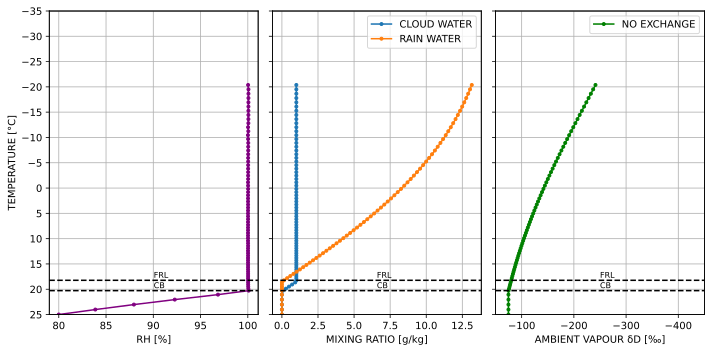

HTML(value="<a href='./fig_4.pdf' target='_blank'>./fig_4.pdf</a><br>")

In [62]:
fig, axs = pyplot.subplots(1, 3, squeeze=False, sharey=True, figsize=(10,5), tight_layout=True)

axs[0,0].set_ylabel('TEMPERATURE [°C]')
axs[0,0].set_ylim(25, -35)
axs[0,0].yaxis.set_major_locator(ticker.MultipleLocator(5))

axs[0,0].plot(
    output['RH'] / const.PER_CENT,
    output['T'] - const.T0,
    marker='.',
    color='purple'
)
axs[0,0].set_xlabel('RH [%]')
axs[0,0].grid()

axs[0,1].plot(
    in_unit(output['QL'], si.g / si.kg),
    output['T'] - const.T0,
    marker='.',
    label='CLOUD WATER'
)
axs[0,1].plot(
    in_unit(output['QR'], si.g / si.kg),
    output['T'] - const.T0,
    marker='.',
    label='RAIN WATER'
)
axs[0,1].set_xlabel('MIXING RATIO [g/kg]')
axs[0,1].grid()
axs[0,1].legend()

axs[0,2].plot(
    in_unit(formulae.trivia.isotopic_ratio_2_delta(
        ratio=output['env_R_2H'],
        reference_ratio=const.VSMOW_R_2H
    ), const.PER_MILLE),
    output['T'] - const.T0,
    marker='.',
    color='green',
    label='NO EXCHANGE'
)
axs[0,2].set_xlabel('AMBIENT VAPOUR δD [‰]')
axs[0,2].set_xlim(-50, -450)
axs[0,2].grid()
axs[0,2].legend()

for ax in axs.squeeze():
    twinx = ax.twiny()
    twinx.set_xlim(0,1)
    twinx.set_xticks([])
    for label, level_index in level_indices.items():
        twinx.plot([0, 1], [output["T"][level_index] - const.T0]*2, color='black', linestyle='--')
        twinx.text(.5, output["T"][level_index] - const.T0 - .5, label, fontsize=8)

show_plot('fig_4.pdf')

In [59]:
def Rv_prim(*, Rl, Nl, Rv, Nv, dNl, Rr, K, a):
    return (
        Rl * Nl + Rv * Nv + dNl * Rr * K
    ) / (
        (Nl + dNl * K) * a + Nv
    )

In [60]:
shape = (len(output["T"]), 400)
data = {k: np.full(shape, np.nan) for k in ("Rv", "Rr")}
data["Rv"][:,0] = output["env_R_2H"]

In [10]:
alpha = formulae.isotope_equilibrium_fractionation_factors.alpha_l_2H(output["T"])
for i in range(shape[1]):
    if i != 0:
        data["Rv"][:, i] = Rv_prim(
            Rv=data["Rv"][:, i - 1],
            Rr=data["Rr"][:, i - 1],
            K=FIG4_CAPTION_PARAMS["isotope_exchange_factor"],
            a=alpha,
            Rl=data["Rr"][:, i - 1],
            Nl=output["QL"],
            Nv=output["QV"],
            dNl=output["QR"]
        )
    data["Rr"][:, i] = alpha * data["Rv"][:, i]

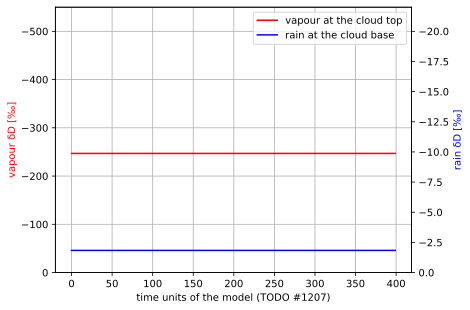

HTML(value="<a href='./fig_5.pdf' target='_blank'>./fig_5.pdf</a><br>")

In [12]:
colors = {'vapour': 'red', 'rain': 'blue'}

lines = []
lines.append(*pyplot.plot(
    in_unit(formulae.trivia.isotopic_ratio_2_delta(
        ratio=data["Rv"][-1,:],
        reference_ratio=const.VSMOW_R_2H
    ), const.PER_MILLE),
    label="vapour at the cloud top",
    color=colors['vapour']
))
pyplot.ylim(0, -550)
pyplot.ylabel('vapour δD [‰]', color=colors['vapour'])
pyplot.xlabel('time units of the model (TODO #1207)')
pyplot.grid()

twinx = pyplot.gca().twinx()
twinx.set_ylim(0, -22)
twinx.set_ylabel('rain δD [‰]', color=colors['rain'])
lines.append(*twinx.plot(
    in_unit(formulae.trivia.isotopic_ratio_2_delta(
        ratio=data["Rr"][0,:],
        reference_ratio=const.VSMOW_R_2H
    ), const.PER_MILLE),
    label="rain at the cloud base",
    color=colors['rain']
))
pyplot.legend(lines, [l.get_label() for l in lines])
show_plot('fig_5.pdf')